In [2]:
import sys
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Callable, Any

import yaml

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
def barplot(df_data: pd.DataFrame, col_main: str, title: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике

    :param df_data: датасет
    :param col_main: признак анализа, по нему происходит нормализация    
    :param title: название графика    
    """
    norm_target = (df_data[col_main].value_counts(
        normalize=True).mul(100).rename("percentage").reset_index())

    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=col_main,
                     y="percentage",
                     hue=col_main,
                     palette='rocket',
                     data=norm_target)

    for container in ax.containers:
        ax.bar_label(container, fontsize=12, fmt='%.2f')

    plt.title(title, fontsize=16)
    plt.xlabel(col_main, fontsize=14)
    plt.ylabel("Percentage", fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    plt.show()


def barplot_group(df_data: pd.DataFrame,
                  col_main: str,
                  col_group: str,
                  title: str,
                  is_horizontal: bool = True,
                  use_bar_labels: bool = True) -> None:
    """
    Построение barplot с группированными и нормированными данными,
    с выводом значений на графике

    :param df_data: датасет
    :param col_main: признак для анализа и нормалиации
    :param col_group: признак для группировки
    :param title: название графика
    :param is_horizontal: признак горизонтальной ориентации графика
    :param use_bar_labels: признак использования меток на столбцах графика
    """
    data = (df_data.groupby(col_group)[col_main].value_counts(
        normalize=True).rename('percentage').mul(
            100).reset_index().sort_values(by=col_group))

    plt.figure(figsize=(15, 7))
    if is_horizontal:
        ax = sns.barplot(x="percentage",
                         y=col_main,
                         hue=col_group,
                         data=data,
                         palette='rocket',
                         orient="h")
        xlabel = 'Percentage'
        ylabel = col_main
    else:
        ax = sns.barplot(x=col_main,
                         y="percentage",
                         hue=col_group,
                         data=data,
                         palette='rocket',
                         orient="v")
        xlabel = col_main
        ylabel = 'Percentage'

    if use_bar_labels:
        for container in ax.containers:
            ax.bar_label(container, fontsize=12, fmt='%.2f')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    sns.move_legend(ax, loc='best', fontsize=14, title_fontsize=14)
    plt.show()


def kdeplot(df_data: pd.DataFrame, x: str, hue: str, title: str,
            xlabel: str) -> None:
    """
    Построение кривой плотности распределения вероятностей

    :param df_data: датасет
    :param x: признак, для которого строится распределение
    :param hue: признак, по которому происходит разбивка на подмножества
    :param title: название графика
    :param xlabel: метка для оси X
    """
    ax = sns.displot(data=df_data,
                     x=x,
                     kind="kde",
                     hue=hue,
                     common_norm=False,
                     palette='rocket',
                     height=6,
                     aspect=2.1)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    sns.move_legend(ax, loc='center right', fontsize=14, title_fontsize=14)
    plt.show()


def boxplot(df_data: pd.DataFrame, x: str, y: str, title: str, xlabel: str,
            ylabel: str) -> None:
    """
    Построение графика boxplot
    :param df_data: датасет
    :param x: признак для отрисовки по оси Х, по нему также будет выполняться группировка
    :param y: признак для отрисовки по оси Y
    :param title: название графика
    :param xlabel: метка для оси X
    :param ylabel: метка для оси Y
    """
    plt.figure(figsize=(7, 6))
    ax = sns.boxplot(x=x, y=y, hue=x, data=df_data, palette='rocket')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    sns.move_legend(ax, loc='center right', fontsize=14, title_fontsize=14)
    plt.show()

# Overview

Данные взяты из соревания на Kaggle. Основная информация по данным представлена здесь https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data

Цель - предсказать, какие клиенты с большей вероятностью не смогут выплатить свои кредиты. Оценка должна быть стабильна с течением времени

Данные для соревнований изначально были преобразованы, есть следующие обозначения для сходных групп преобразований:
- P - Преобразование DPD (просроченных дней)
- M - Маскировка категорий
- A - Преобразование сумм
- D - Преобразование дат
- T, L - Прочие преобразования
Преобразования внутри группы обозначаются заглавной буквой в конце имени предиктора.

Будем рассматривать только выборку данных из 100 000 объектов, которые уже предварительно объединены, частично отфильтрованы и сконвертированы, согласно вышеприведенному описанию.
Основные колонки:
- case_id -  уникальный идентификатор для каждого кредитного кейса. Этот идентификатор понадобится вам для объединения соответствующих таблиц с базовой таблицей.
- moth_decision, weekday_decision -  месяц и день недели, когда было принято решение об одобрении кредита.
- moth_decision -  дата, когда было принято решение об одобрении кредита.
- WEEK_NUM - номер недели, используемый для агрегирования. Будет использоваться в оценке стабильности по Джини
- **target - целевое значение, определяемое по истечении определенного периода времени в зависимости от того, допустил ли клиент дефолт по конкретному кредитному делу (займу).**

Определения всех остальных столбцов можно найти в файле feature_definitions.csv, но т.к. исторические данные были сгруппированы, то часть столбцов имеет префиксы:
 - "max_" - маскимальное значение
 - "mean_" - среднее значение
 - "mode_" - мода
 - "last_" - последнее значение

In [4]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc_config = config['preprocessing']

# EDA

## Общий обзор

In [5]:
preproc_config['train_path']

'../data/raw/train.parquet'

In [6]:
df = pd.read_parquet(preproc_config['train_path'])
df[:5]

,case_id,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_304L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,validfrom_1069D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L,mean_actualdpd_943P,mean_annuity_853A,max_approvaldate_319D,mean_byoccupationinc_3656910L,mode_cancelreason_3545846M,mean_childnum_21L,max_creationdate_885D,mean_credacc_actualbalance_314A,mean_credacc_credlmt_575A,mean_credacc_maxhisbal_375A,mean

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 322 entries, case_id to weekday_decision
dtypes: Int64(119), float64(110), int64(32), int8(2), object(59)
memory usage: 255.7+ MB


In [6]:
date_columns = [col for col in df.columns if col[-1] == "D"]
df[date_columns].describe()

,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,dtlastpmtallstes_4499206D,firstclxcampaign_1125D,firstdatedue_489D,lastactivateddate_801D,lastapplicationdate_877D,lastapprdate_640D,lastdelinqdate_224D,lastrejectdate_50D,maxdpdinstldate_3546855D,validfrom_1069D,assignmentdate_4527235D,birthdate_574D,dateofbirth_337D,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,max_approvaldate_319D,max_creationdate_885D,max_dateactivated_425D,max_dtlastpmt_581D,max_dtlastpmtallstes_3545839D,max_employedfrom_700D,max_firstnonzeroinstldate_307D,max_recorddate_4527225D,max_deductiondate_4917603D,max_processingdate_168D,max_dateofcredend_289D,max_dateofcredend_353D,max_dateofcredstart_181D,max_dateofcredstart_739D,max_dateofrealrepmt_138D,max_lastupdate_1112D,max_lastupdate_388D,max_numberofoverdueinstlmaxdat_148D,max_numberofoverdueinstlmaxdat_641D,max_overdueamountmax2date_1002D,max_overdueamountmax2date_1142D,max_refreshdate_3813885D,max_openingdate_857D,last_openingdate_313D,birth_259D,empl_employedfrom_271D
count,44878.0000,8673.0000,41558.0000,43576.0000,43236.0000,68069.0000,69934.0000,79855.0000,70726.0000,35446.0000,49372.0000,45475.0000,9785.0000,10450.0000,29038.0000,91261.0000,47095.0000,62578.0000,8592.0000,70646.0000,79855.0000,69844.0000,53500.0000,63582.0000,63513.0000,77790.0000,43786.0000,5300.0000,31841.0000,83296.0000,68052.0000,68052.0000,83296.0000,68039.0000,83296.0000,68052.0000,48485.0000,33880.0000,48156.0000,34174.0000,91261.0000,6734.0000,6746.0000,100000.0000,38948.0000
mean,2452.4469,1937.6118,969.8210,415.7922,989.3094,1825.7156,633.0797,469.0088,612.5154,532.0503,824.4677,1008.7423,19.3211,-13.9478,43.1754,43.7237,-13.8271,-13.9583,-13.5022,611.9938,469.0088,632.5609,313.8584,153.3719,3323.0192,497.4932,-13.9543,8.4866,2.3348,-799.5155,179.6024,847.2527,448.2761,420.3135,-4.5140,387.3231,1127.8493,498.4504,1182.0982,534.3751,-13.7874,1545.8335,1558.0909,43.8252,2176.6929
std,1620.6061,1559.6900,1258.9356,851.4133,464.5635,1454.2636,915.1983,750.5809,898.6569,634.1219,998.3733,1216.1863,30.7865,0.3921,13.9882,13.7496,1.1970,0.3660,1.9654,898.2698,750.5809,914.8622,325.4873,287.1619,2615.1883,802.9500,0.3877,14.3199,26.9303,906.4867,1245.4190,929.5503,645.1850,696.2109,6.8322,651.4927,1119.0657,598.2059,1072.2473,635.6960,0.8915,440.2625,442.0462,13.9585,2239.5196
min,-13.0000,26.0000,-13.0000,-13.0000,-14.0000,-46.0000,-14.0000,-14.0000,-14.0000,-13.0000,-14.0000,-13.0000,-14.0000,-14.0000,20.0000,0.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,19.0000,-46.0000,-14.0000,-13.0000,-14.0000,-9144.0000,-28687.0000,-12.0000,-14.0000,-3159.0000,-14.0000,-14.0000,-13.0000,-14.0000,-13.0000,-14.0000,-14.0000,533.0000,533.0000,20.0000,-13.0000
25%,956.0000,682.0000,101.0000,1.0000,741.7500,566.0000,142.0000,75.0000,135.0000,71.0000,135.0000,161.0000,-6.0000,-14.0000,31.0000,32.0000,-14.0000,-14.0000,-14.0000,135.0000,75.0000,142.0000,72.0000,-4.0000,1490.0000,60.0000,-14.0000,0.0000,-14.0000,-901.0000,-55.0000,313.0000,84.0000,63.0000,-8.0000,54.0000,324.0000,61.0000,376.7500,76.0000,-14.0000,1201.0000,1209.0000,32.0000,638.0000
50%,1990.0000,1427.0000,432.0000,39.0000,1101.0000,1499.0000,309.0000,216.0000,300.0000,296.0000,428.0000,495.0000,12.0000,-14.0000,41.0000,42.0000,-14.0000,-14.0000,-14.0000,299.0000,216.0000,309.0000,208.0000,13.0000,2579.0000,217.0000,-14.0000,7.0000,-6.0000,-606.0000,97.0000,513.0000,197.0000,181.0000,-5.0000,171.0000,701.0000,220.0000,826.0000,251.0000,-14.0000,1536.0000,1558.0000,42.0000,1415.0000
75%,4231.0000,3391.0000,1304.0000,378.0000,1342.0000,2775.0000,645.0000,494.0000,626.0000,792.0000,1146.2500,1402.0000,37.0000,-14.0000,55.0000,55.0000,-14.0000,-14.0000,-14.0000,626.0000,494.0000,645.0000,451.0000,182.0000,4447.0000,537.0000,-14.0000,14.0000,9.0000,-367.0000,357.0000,939.0000,464.0000,435.0000,-2.0000,399.0000,1562.0000,765.0000,1638.0000,808.7500,-14.0000,1893.0000,1909.0000,55.0000,2931.0000
max,4891.0000,5202.00

In [7]:
numeric_columns = [
    col for col in df.select_dtypes(
        exclude=["object", "bool"]).columns
    if col[-1] != "D" and col not in ["target", "case_id", "WEEK_NUM"]
]
df[numeric_columns].describe()

,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_304L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,daysoverduetolerancedd_3976961L,disbursedcredamount_1113A,downpmt_116A,eir_270L,homephncnt_628L,inittransactionamount_650A,interestrate_311L,lastapprcredamount_781A,lastrejectcredamount_222A,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,contractssum_5085716L,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,fourthquarter_440L,numberofqueries_373L,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,riskassesment_940T,secondquarter_766L,thirdquarter_1082L,mean_actualdpd_943P,mean_annuity_853A,mean_byoccupationinc_3656910L,mean_childnum_21L,mean_credacc_actualbalance_314A,mean_credacc_credlmt_575A,mean_credacc_maxhisbal_375A,mean_credacc_minhisbal_90A,mean_credacc_transactions_402L,mean_credamount_590A,mean_currdebt_94A,mean_downpmt_134A,mean_mainoccupationinc_437A,mean_maxdpdtolerance_577P,mean_outstandingdebt_522A,mean_pmtnum_8L,mean_revolvingaccount_394A,mean_tenor_203L,mean_amount_4527230A,mean_amount_4917619A,mean_pmtamount_36A,mean_annualeffectiverate_199L,mean_annualeffectiverate_63L,mean_contractsum_5085717L,mean_credlmt_230A,mean_credlmt_935A,mean_debtoutstand_525A,mean_debtoverdue_47A,mean_dpdmax_139P,mean_dpdmax_757P,max_dpdmaxdatemonth_442T,max_dpdmaxdatemonth_89T,max_dpdmaxdateyear_596T,max_dpdmaxdateyear_896T,mean_instlamount_768A,mean_instlamount_852A,mean_monthlyinstlamount_332A,mean_monthlyinstlamount_674A,mean_nominalrate_281L,mean_nominalrate_498L,mean_numberofcontrsvalue_258L,mean_numberofcontrsvalue_358L,mean_numberofinstls_229L,mean_numberofinstls_320L,mean_numberofoutstandinstls_520L,mean_numberofoutst

In [9]:
df.describe(include=["object", "bool"])

,cardtype_51L,credtype_322L,disbursementtype_67L,equalitydataagreement_891L,inittransactioncode_186L,isbidproduct_1095L,lastapprcommoditycat_1041M,lastcancelreason_561M,lastrejectcommoditycat_161M,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,opencred_647L,twobodfilling_608L,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,requesttype_4525192L,riskassesment_302T,mode_cancelreason_3545846M,mode_credtype_587L,mode_education_1138M,mode_familystate_726L,mode_inittransactioncode_279L,mode_isbidproduct_390L,mode_postype_4733339M,mode_rejectreason_755M,mode_rejectreasonclient_4145042M,mode_status_219L,mode_classificationofcontr_13M,mode_classificationofcontr_400M,mode_contractst_545M,mode_contractst_964M,mode_description_351M,mode_financialinstitution_382M,mode_financialinstitution_591M,mode_periodicityofpmts_1102L,mode_purposeofcred_426M,mode_purposeofcred_874M,education_927M,empl_employedtotal_800L,empl_industry_691L,familystate_447L,incometype_1044T,language1_981M,role_1084L,safeguarantyflag_411L,sex_738L,type_25L,mode_cacccardblochreas_147M,mode_empls_economicalst_849M,mode_cacccardblochreas_147M_right,mode_collater_typofvalofguarant_298M,mode_collater_typofvalofguarant_407M,mode_collaterals_typeofguarante_359M,mode_collaterals_typeofguarante_669M,mode_subjectroles_name_541M
count,12995,100000,99851,5060,100000,100000,100000,100000,100000,100000,100000,79855,79855,99992,98732,98732,98732,98732,98732,63763,3259,79855,79236,79855,55354,79301,79855,79855,79855,79855,79855,91295,91295,91295,91295,91295,91295,91295,26089,91295,91295,100000,37428,36995,48491,100000,100000,100000,100000,100000,100000,78238,94711,78238,91244,91244,91244,91244,91244
unique,2,3,3,2,3,2,37,59,36,17,11,10,2,2,2,5,5,6,6,3,16,47,3,6,5,3,2,9,14,11,10,4,44,3,9,10,96,13,1,3,14,6,3,23,5,9,3,2,2,2,4,4,9,3,2,2,1,2,1
top,INSTANT,COL,SBA,true,POS,false,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,D,false,FO,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,DEDUCTION_6,3% - 4%,a55475b1,COL,a55475b1,MARRIED,POS,false,a55475b1,a55475b1,a55475b1,K,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,30.0,a55475b1,a55475b1,a55475b1,MORE_FIVE,OTHER,MARRIED,PRIVATE_SECTOR_EMPLOYEE,P10_39_147,CL,true,F,PRIMARY_MOBILE,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
freq,12866,64777,75140,4730,75245,88481,55336,70264,79574,62374,64445,25446,76625,97001,90398,56840,97701,43955,97322,52609,401,62967,50664,34197,40572,54072,79282,50353,67192,67754,38149,90959,61576,90824,57362,91261,66758,91253,26089,91096,62649,51509,26282,27453,32915,33067,56172,82540,96461,62541,98180,78232,94068,78234,91243,91242,91244,91243,91244


Проверим, есть ли пропуски в данных

In [10]:
round(df.isna().sum()[df.isna().sum() > 0] / df.shape[0] * 100, 2)

actualdpdtolerance_344P                27.6400
amtinstpaidbefduel24m_4187115A         36.4200
avgdbddpdlast24m_3658932P              40.5300
avgdbddpdlast3m_4187120P               61.8200
avgdbdtollast24m_4525197P              55.8800
avgdpdtolclosure24_3658938P            31.0000
avginstallast24m_3658937A              41.3500
avglnamtstart24m_4525187A              86.6900
avgmaxdpdlast9m_3716943P               50.0100
avgoutstandbalancel6m_4187114A         54.8700
avgpmtlast12m_4525200A                 60.1200
cardtype_51L                           87.0000
cntincpaycont9m_3716944L               30.2000
cntpmts24_3658933L                     30.8200
datefirstoffer_1144D                   55.1200
datelastinstal40dpd_247D               91.3300
datelastunpaid_3546854D                58.4400
daysoverduetolerancedd_3976961L        30.0000
disbursementtype_67L                    0.1500
dtlastpmtallstes_4499206D              56.4200
eir_270L                               12.9400
equalitydataa

**Выводы**
- В датасете много признаков с большим количеством пропусков

### Target
Посмотрим на целевую переменную target, есть ли дисбаланс классов.

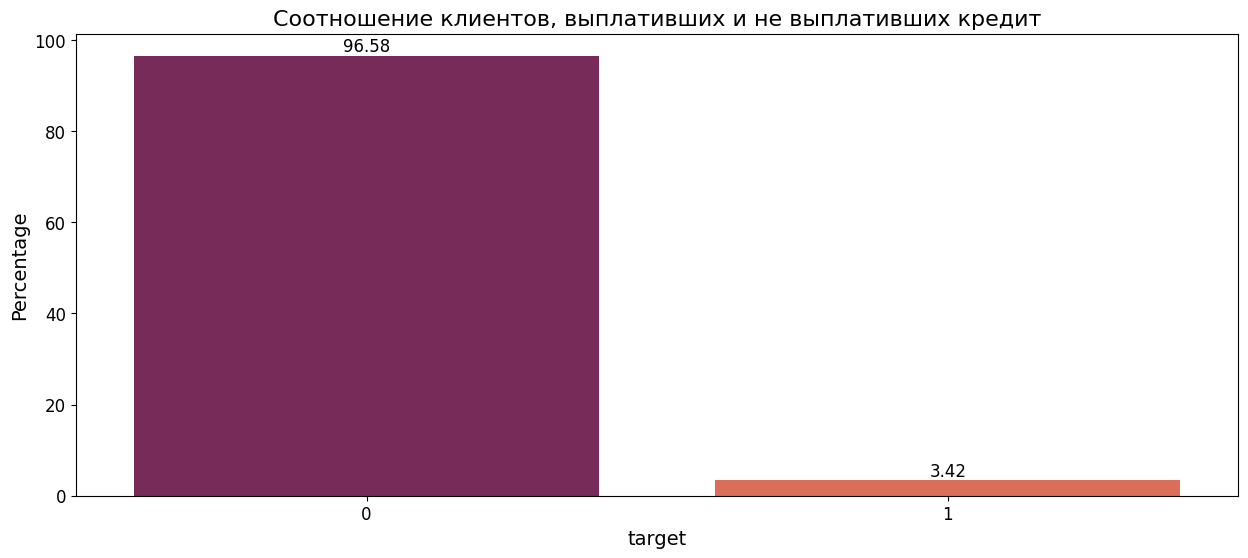

In [11]:
barplot(df_data=df,
        col_main="target",
        title="Соотношение клиентов, выплативших и не выплативших кредит")

- И на рапределение целевой переменной в разрезе WEEK_NUM

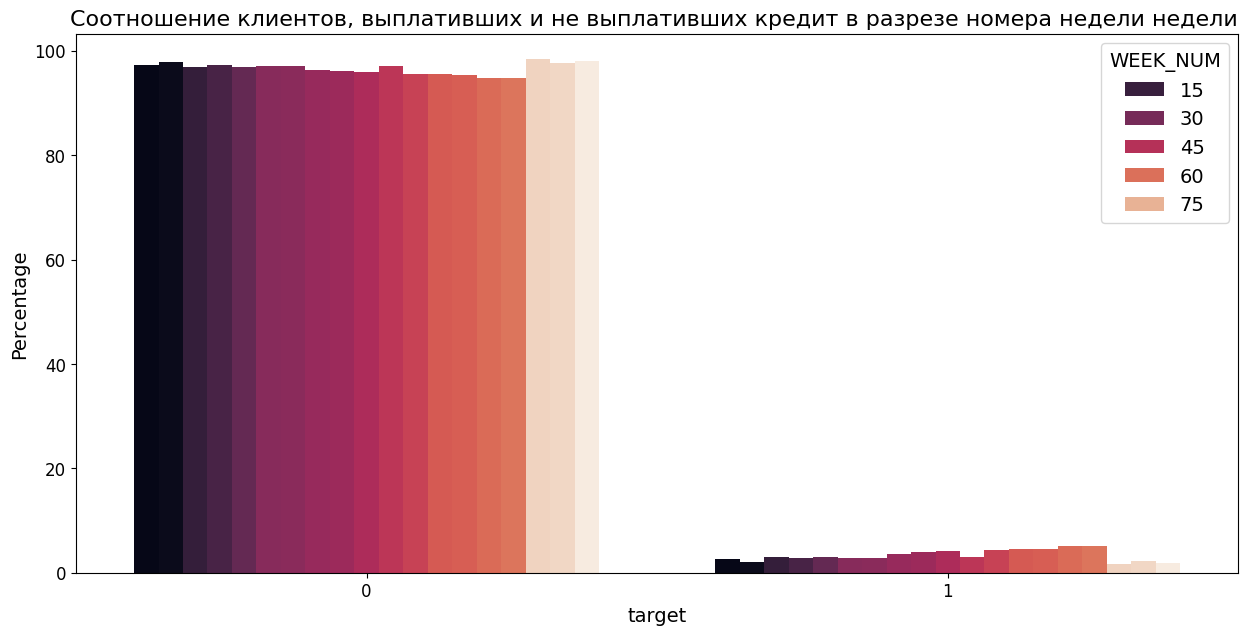

In [12]:
barplot_group(
    df_data=df,
    col_main="target",
    col_group="WEEK_NUM",
    title=
    "Соотношение клиентов, выплативших и не выплативших кредит в разрезе номера недели недели ",
    is_horizontal=False,
    use_bar_labels=False)

**Выводы**
- Выборка очень сильно несбалансированная
- Каждую неделю есть небольшой процент target=1 (клиентов, допустивших дефолт по кредиту)

### Возраст

In [13]:
age_columns = [col for col in df.columns if "birth" in col]

print("-------Train-------")
for col in age_columns:
    is_null = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(is_null*100)))
    
df[age_columns].describe()

-------Train-------
birthdate_574D - 71%
dateofbirth_337D - 9%
birth_259D - 0%


,birthdate_574D,dateofbirth_337D,birth_259D
count,29038.0000,91261.0000,100000.0000
mean,43.1754,43.7237,43.8252
std,13.9882,13.7496,13.9585
min,20.0000,0.0000,20.0000
25%,31.0000,32.0000,32.0000
50%,41.0000,42.0000,42.0000
75%,55.0000,55.0000,55.0000
max,75.0000,105.0000,75.0000


In [14]:
not_matching_ages = df[age_columns][df[age_columns]["birth_259D"] !=
                                    df[age_columns]["dateofbirth_337D"]]
print(not_matching_ages.shape)
not_matching_ages[:10]

(83, 3)


,birthdate_574D,dateofbirth_337D,birth_259D
96,<NA>,43,44
877,59,58,59
4380,<NA>,38,37
5339,<NA>,61,51
6012,67,66,67
7162,<NA>,62,61
11066,<NA>,62,44
11743,<NA>,32,52
12104,32,33,32
12737,<NA>,45,40


**Выводы**
 - Большая часть значений birth_259D и dateofbirth_337D совпадает
 - В dateofbirth_337D  есть пропуски и есть выбросы (есть ошибки в данных)

### Category

Посмотрим на категориальные признаки, у которых много уникальных значений

In [8]:
cat_columns = df.select_dtypes("object").columns.to_list()
for col in cat_columns:
    cnts = df[col].value_counts(dropna=True, normalize=True)
    nunique = df[col].nunique()
    if nunique > 20:
        print('{0}: {1}'.format(col, nunique))
        print(cnts)
        print()

lastapprcommoditycat_1041M: 37
lastapprcommoditycat_1041M
a55475b1       0.5534
P159_130_59    0.1710
P12_6_178      0.1038
P148_110_5     0.0409
P109_133_183   0.0367
P53_45_92      0.0206
P52_56_90      0.0148
P33_29_177     0.0136
P100_96_175    0.0121
P21_79_33      0.0115
P128_43_169    0.0065
P184_3_97      0.0045
P201_79_148    0.0019
P187_118_47    0.0018
P65_94_74      0.0017
P105_126_172   0.0013
P216_109_183   0.0010
P177_46_174    0.0007
P121_6_80      0.0006
P160_128_10    0.0004
P48_73_87      0.0004
P21_123_87     0.0003
P143_21_170    0.0001
P137_157_60    0.0001
P110_120_162   0.0001
P75_42_174     0.0001
P141_125_135   0.0001
P76_145_175    0.0001
P156_122_160   0.0000
P98_19_172     0.0000
P193_109_73    0.0000
P137_6_96      0.0000
P49_162_170    0.0000
P175_82_175    0.0000
P3_103_80      0.0000
P38_69_128     0.0000
P181_140_94    0.0000
Name: proportion, dtype: float64

lastcancelreason_561M: 59
lastcancelreason_561M
a55475b1       0.7026
P94_109_143    0.1982
P8

**Выводы**
- есть категориальные признаки с большим количеством уникальных значений, при том что большинство этих уникальных значений встречается очень редко => редко встречаемые можно объединить в один вариант

## Гипотезы

### Age 
**Гипотеза**: Возрастные клиенты более платежеспобные, т.е. распределения возраста в зависимости от флага дефолта смещено в большую сторону при default=0

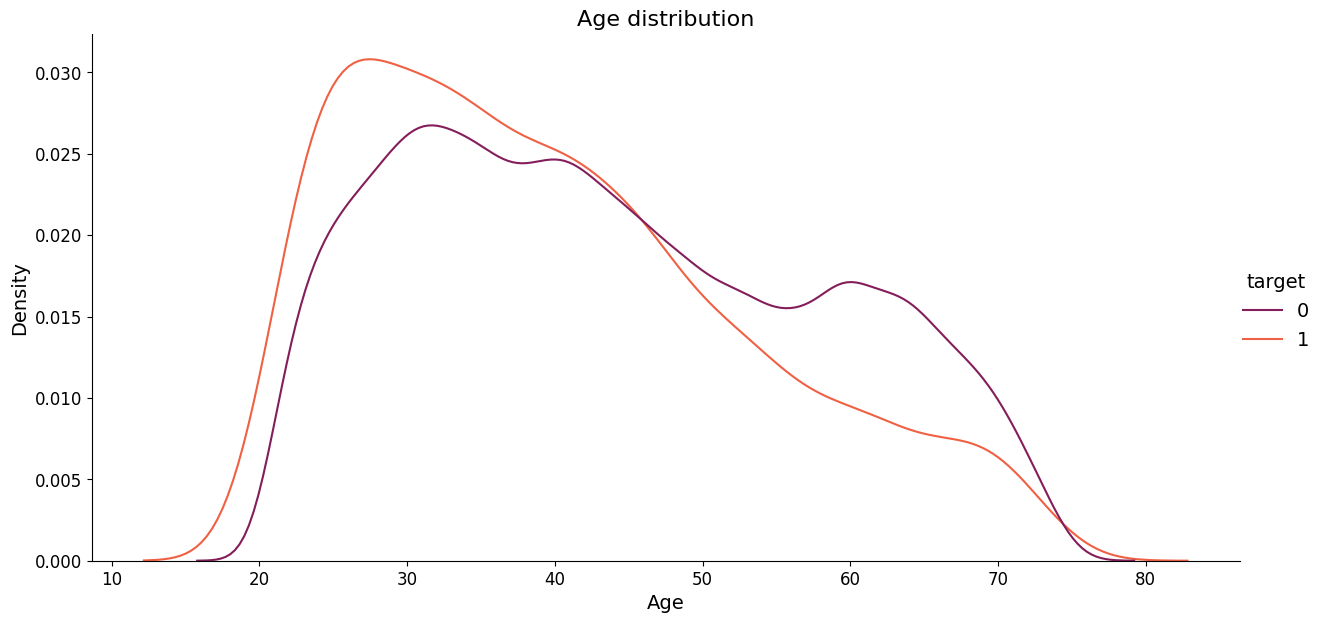

In [8]:
kdeplot(df_data=df,
        x="birth_259D",
        hue="target",
        title='Age distribution',
        xlabel='Age')

**Выводы**
- Выборки сильно не отличаются, но все же есть небольшие отличия;
- для target=1 (дефолт) пик возраста находится на 20-30 лет, т.е. среди клиентов с дефолтом больше молодых;
- для target=0 два основных пика: около 30 лет и около 60 лет
- гипотеза отчасти подтвердилась

### Ежемесячный платеж 

**Гипотеза:** чем выше ежемесячный платеж, тем больше вероятность не выплатить кредит

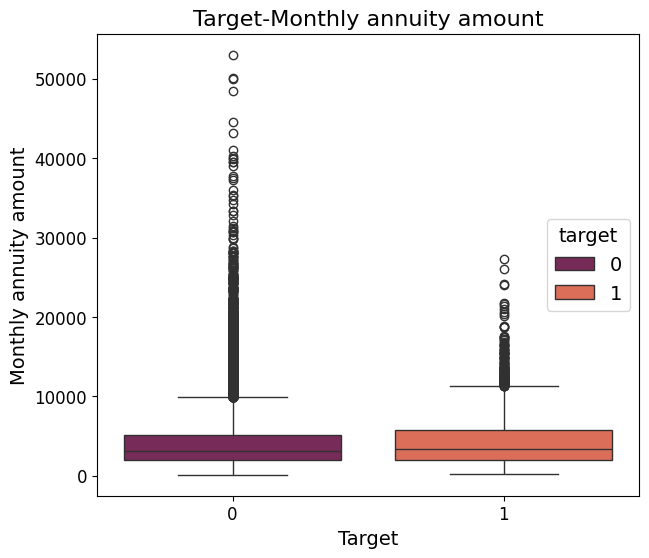

In [9]:
boxplot(
    df_data=df,
    x="target",
    y="annuity_780A",
    title="Target-Monthly annuity amount",
    xlabel="Target",
    ylabel="Monthly annuity amount"
)

In [18]:
df[["annuity_780A", "target"]].groupby("target").describe()

annuity_780A                                                   \
              count      mean       std      min       25%       50%   
target                                                                 
0        96577.0000 3985.2140 2974.4609 126.2000 1936.2001 3100.0000   
1         3423.0000 4334.6454 3267.9307 158.4000 1977.9000 3315.2000   

                             
             75%        max  
target                       
0      5135.0000 53019.0000  
1      5714.8000 27272.6000

**Выводы**
- значительных отличий нет, но среднее значение, а также значение между Q1 и Q3 для target=1 немного выше, чем для target=0
- при target=0 разброс значений больше
- гипотеза отчасти подтвердилась

###  Cумма налоговых вычетов

**Гипотеза:** чем выше сумма налоговых вычетов, тем выше платежеспособность клиента, а значит тем выше вероятность класса 0.

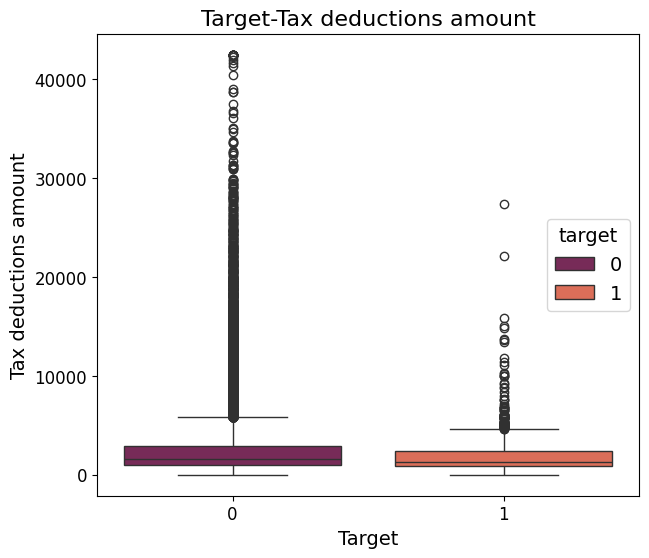

In [10]:
boxplot(
    df_data=df,
    x="target",
    y="mean_amount_4527230A",
    title="Target-Tax deductions amount",
    xlabel="Target",
    ylabel="Tax deductions amount"
)

**Выводы**
- значительных отличий нет, но среднее значение для target=0 немного выше, чем для target=1
- при target=0 разброс значений больше
- гипотеза отчасти подтвердилась

### Riskassesment (Предполагаемая вероятность того, что клиент совершит дефолт)

**Гипотеза:** riskassesment (Предполагаемая вероятность того, что клиент совершит дефолт) взаимосвязан напрямую с default: чем он выше, тем ниже вероятность клиента выплатить кредит банку

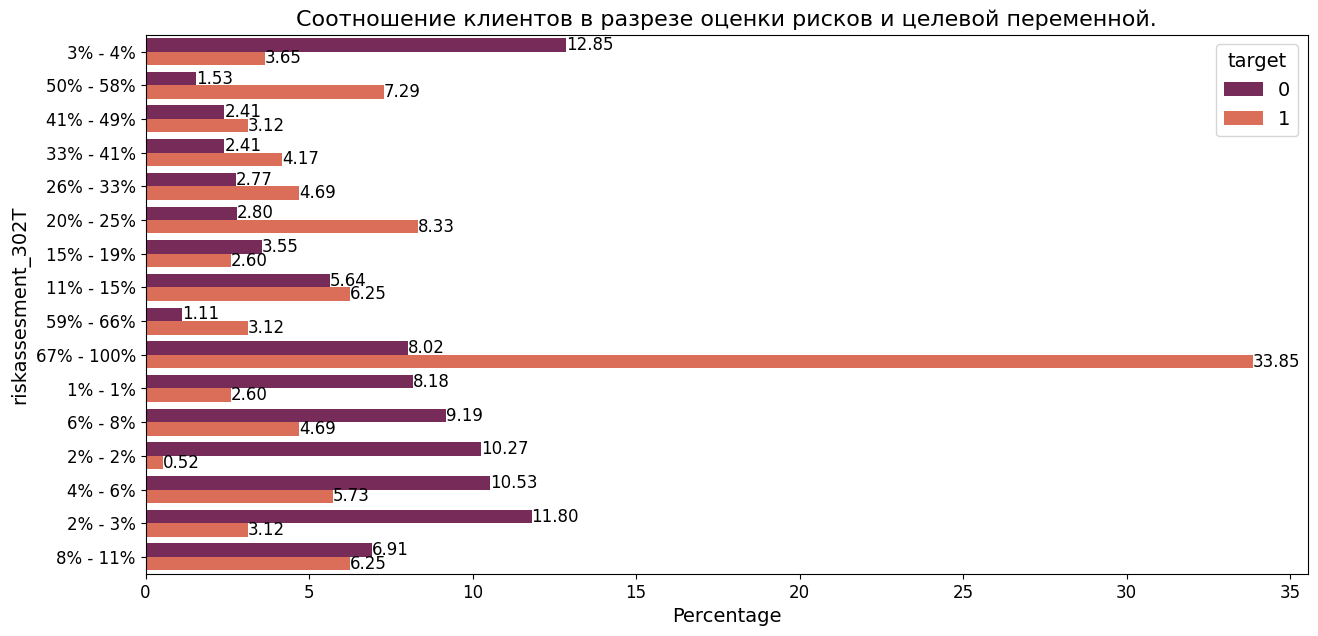

In [11]:
barplot_group(
    df_data=df,
    col_main="riskassesment_302T",
    col_group="target",
    title= "Соотношение клиентов в разрезе оценки рисков и целевой переменной."
)

**Выводы**
- Для target=1 (дефолт) большой процент клиентов с предполагаемой вероятностью дефолта от 67%
- Для target=0 ожидаемо больше клиентов с низкой предполагаемой вероятностью дефолта
- Гипотеза подтвердилась

# Feature tranformation, selection and engineering 

- Заполним пропуски, отфильтруем фичи и создадим новые

In [16]:
def get_bins(data: (int, float), first_val: (int, float),
             second_val: (int, float)) -> str:
    """
    Генерация бинов для разных признаков
    :param data: числовое значение
    :param first_val: первый порог значения для разбиения на бины
    :param second_val: второй порог значения для разбиения на бины
    :return: наименование бина
    """
    assert isinstance(data, (int, float)), "Проблема с типом данных в признаке"
    result = ("small" if data <= first_val else
              "medium" if first_val < data <= second_val else "large")
    return result


def fill_nans(df_data: pd.DataFrame, value: Any,
              columns: list[str]) -> pd.DataFrame:
    """
    Заполняет пропуски переданным значением
    :param df_data: датасет
    :param value: значение, которым необходимо заполнить пропуску
    :param columns: список признаков
    :return: датасет
    """
    for column in columns:
        if np.mean(df_data[column].isnull()) > 0:
            df_data[column] = df_data[column].fillna(value)
    return df_data


def merge_columns(df_data: pd.DataFrame, main_column: str, add_column: str,
                  new_column: str) -> pd.DataFrame:
    """
    Объединение двух дублирующихся признаков в один.
    Если значение в main_column заполнено то берется это значение, 
    иначе берется значение из add_column
    :param df_data: датасет
    :param main_column: основная признак
    :param add_column: дополнительный признак
    :param new_column: название нового признака
    :return: датасет
    """
    df_data[new_column] = df_data.apply(
        lambda x: x[add_column]
        if pd.isnull(x[main_column]) else x[main_column],
        axis=1).astype(df_data[main_column].dtype)

    df_data = df_data.drop([main_column, add_column], axis=1)
    return df_data


def replace_rare_values(df_data: pd.DataFrame,
                        columns: dict,
                        value: Any = "Other"):
    """
    Замена редко встречающихся значений 
    :param df_data: датасет
    :param columns: словарь, где key - имя столбца, 
                    value - порог, при котором заменяется значение столбца, 
                    если его частота ниже
    :param value: новое значение    
    :return: датасет
    """

    for column in columns.keys():
        nunique = df_data[column].nunique()
        rare_values = df_data[column].value_counts(
            dropna=True, normalize=True)[df_data[column].value_counts(
                dropna=True, normalize=True) < columns[column]].index

        df_data[column] = df_data[column].apply(lambda x: "Other"
                                                if x in rare_values else x)
        print(
            f"{column} reduced nunique from {nunique} to {df_data[column].nunique()}"
        )
    return df_data


def drop_columns_by_corr_matrix(df_data: pd.DataFrame,
                                except_columns: list[str],
                                threshold: float = 0.9,
                                debug=False) -> pd.DataFrame:
    """
    Удаление сильно скоррелированных признаков
    :param df_data: датасет
    :param except_columns: исключаемые признаки
    :param threshold: порог, при котором признак удаляется
    :return: датасет
    """
    cor_matrix = df_data.drop(columns=except_columns,
                              axis=1).corr(method='spearman',
                                           numeric_only=True).abs()
    cor_matrix = cor_matrix.where(
        np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

    to_drop = [
        column for column in cor_matrix.columns
        if any(cor_matrix[column] > threshold)
    ]

    if debug:
        for column in to_drop:
            print(column)
            print(cor_matrix[column][cor_matrix[column] > threshold])
            print()
    return df_data.drop(to_drop, axis=1)


def filter_columns_with_nulls(df_data: pd.DataFrame,
                              threshold: float = 0.99) -> pd.DataFrame:
    """
    Фильтрация колонок с пропусками
    :param df_data: датасет    
    :param threshold: порог, при котором признак удаляется
    :return: датасет
    """
    columns_to_drop = []
    for column in df_data.columns:
        is_null = np.mean(df_data[column].isnull())
        if is_null > threshold:
            columns_to_drop.append(column)
            print(f"column to drop: {column}, is_null:{is_null}")

    if (any(columns_to_drop)):
        df_data = df_data.drop(columns_to_drop, axis=1)
        print(f"dropped columns count: {len(columns_to_drop)}")
    return df_data


def transform_types(df_data: pd.DataFrame,
                    change_type_columns: dict) -> pd.DataFrame:
    """
    Преобразование признаков в заданный тип данных
    :param df_data: датасет
    :param change_type_columns: словарь с признаками и типами данных
    :return:
    """
    return df_data.astype(change_type_columns, errors="raise")


def save_unique_train_data(df_data: pd.DataFrame, drop_columns: list,
                           unique_values_path: str) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями для категориальных переменных 
    и статистическими значениями для числовых переменных
    :param df_data: датасет
    :param drop_columns: список с признаками для удаления    
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    unique_df = df_data.drop(columns=drop_columns, axis=1, errors="ignore")

    category_columns = unique_df.select_dtypes(["object", "bool",
                                                "category"]).columns.to_list()
    dict_unique = {
        key:
        unique_df[key].unique().tolist()
        if key in category_columns else unique_df[key].describe().tolist()
        for key in unique_df.columns
    }

    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file)

In [7]:
df.shape

(100000, 322)

Удалим признаки, в которых не заполнены значения

In [8]:
df = filter_columns_with_nulls(df, threshold=0.99)
df.shape

(100000, 322)

Как видим, в данном датасете нет признаков, в которых нет ни одного значения

Объединим дублирующиеся признаки

In [9]:
preproc_config["map_merge_columns"]

{'age': ['birth_259D', 'dateofbirth_337D']}

In [10]:
df[preproc_config["map_merge_columns"]["age"]].describe()

,birth_259D,dateofbirth_337D
count,100000.0000,91261.0000
mean,43.8252,43.7237
std,13.9585,13.7496
min,20.0000,0.0000
25%,32.0000,32.0000
50%,42.0000,42.0000
75%,55.0000,55.0000
max,75.0000,105.0000


In [11]:
map_merge_columns = preproc_config["map_merge_columns"]
for key in map_merge_columns.keys():
    df = merge_columns(df,
                       main_column=map_merge_columns[key][0],
                       add_column=map_merge_columns[key][1],
                       new_column=key)

Сгенерируем бины

In [12]:
preproc_config["map_bins_columns"]

{'age': [35, 55]}

In [13]:
map_bins_columns = preproc_config["map_bins_columns"]
for key in map_bins_columns.keys():
    df[f"{key}_bins"] = df[key].apply(lambda x: get_bins(
        x,
        first_val=map_bins_columns[key][0],
        second_val=map_bins_columns[key][1],
    ))

В категориальных признаках, у которых высокая вариативность значений, заменим редко встречающиеся значения на значение "Other"

In [14]:
preproc_config["map_replace_rare_values"]

{'lastapprcommoditycat_1041M': 0.001,
 'lastcancelreason_561M': 0.001,
 'lastrejectcommoditycat_161M': 0.001,
 'mode_cancelreason_3545846M': 0.001,
 'mode_classificationofcontr_400M': 0.0001,
 'mode_contractst_964M': 0.0002,
 'mode_financialinstitution_382M': 0.001,
 'mode_financialinstitution_591M': 0.0001}

In [17]:
df = replace_rare_values(df, preproc_config["map_replace_rare_values"])

lastapprcommoditycat_1041M reduced nunique from 18 to 18
lastcancelreason_561M reduced nunique from 59 to 18
lastrejectcommoditycat_161M reduced nunique from 36 to 15
mode_cancelreason_3545846M reduced nunique from 47 to 12
mode_classificationofcontr_400M reduced nunique from 44 to 13
mode_contractst_964M reduced nunique from 9 to 4
mode_financialinstitution_382M reduced nunique from 96 to 18
mode_financialinstitution_591M reduced nunique from 13 to 3


Заполним пропуски значениеи:
- 0 - для числовых признаков
- "Unknown" - для категориальных

In [18]:
cat_columns = df.select_dtypes("object").columns.to_list()
numeric_columns = df.select_dtypes(
    exclude=["object", "bool", "category"]).columns.to_list()

In [19]:
df = fill_nans(df, value="Unknown", columns=cat_columns)
df = fill_nans(df, value=0, columns=numeric_columns)

In [20]:
round(df.isna().sum()[df.isna().sum() > 0] / df.shape[0] * 100, 2)

Series([], dtype: float64)

Удалим признаки, которые не будут участвовать в обучении

In [21]:
preproc_config['drop_columns']

['case_id']

In [22]:
df = df.drop(preproc_config['drop_columns'], axis=1)

Удалим сильно скоррелированные признаки

In [23]:
preproc_config["corr_matrix_settings"]

{'enable': True, 'threshold': 0.9}

In [24]:
except_columns = [
    preproc_config["target_column"], preproc_config["groups_column"]
]
except_columns

['target', 'WEEK_NUM']

In [25]:
corr_matrix_settings = preproc_config["corr_matrix_settings"]
df = drop_columns_by_corr_matrix(df,
                                 except_columns=except_columns,
                                 threshold=corr_matrix_settings["threshold"],
                                 debug=True)

currdebt_22A
annuitynextmonth_57A   0.9193
Name: currdebt_22A, dtype: float64

disbursedcredamount_1113A
credamount_770A   0.9083
Name: disbursedcredamount_1113A, dtype: float64

interestrate_311L
eir_270L   1.0000
Name: interestrate_311L, dtype: float64

lastapprdate_640D
lastactivateddate_801D   0.9252
Name: lastapprdate_640D, dtype: float64

maxdpdlast9m_1059P
maxdpdlast12m_727P   0.9245
Name: maxdpdlast9m_1059P, dtype: float64

maxdpdtolerance_374P
daysoverduetolerancedd_3976961L   0.9292
Name: maxdpdtolerance_374P, dtype: float64

maxinstallast24m_3658928A
avginstallast24m_3658937A   0.9694
Name: maxinstallast24m_3658928A, dtype: float64

maxlnamtstart6m_4525199A
avgpmtlast12m_4525200A   0.9089
Name: maxlnamtstart6m_4525199A, dtype: float64

maxoutstandbalancel12m_4187113A
avgoutstandbalancel6m_4187114A   0.9247
Name: maxoutstandbalancel12m_4187113A, dtype: float64

numincomingpmts_3546848L
monthsannuity_845L   0.9866
Name: numincomingpmts_3546848L, dtype: float64

numinstlallpaid

In [26]:
df.shape

(100000, 245)

Переведем признаки c типом object в category

In [25]:
category_maps = {
    key: "category"
    for key in df.select_dtypes(["object"]).columns
}
df = transform_types(df_data=df, change_type_columns=category_maps)

# Saving data

In [26]:
preproc_config["train_path_proc"]

'../data/processed/train.parquet'

In [27]:
df.to_parquet(preproc_config["train_path_proc"], index=False)

In [28]:
preproc_config["unique_values_path"]

'../data/processed/unique_values.json'

In [27]:
save_unique_train_data(
    df_data=df,
    drop_columns=[
        preproc_config["target_column"], preproc_config["groups_column"]
    ],
    unique_values_path=preproc_config["unique_values_path"],
)